In [1]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
import string
import copy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

## Class for naive bayes classifier

In [2]:
class NBClassifier:
    def __init__(self, path=""):
        
        # get paths
        self.train_data_path = path+"train.csv"
        self.test_data_path = path+"test.csv"
        
        # get training data
        self.train_data = pd.read_csv(self.train_data_path, header=0)
        
        # extract useful columns
        self.train_data = self.train_data[['Text', 'Label']]
        
        # get test data
        self.test_data = pd.read_csv(self.test_data_path, header=0)
        
        # extract useful columns
        self.test_data = self.test_data[['Text', 'Label']]
        
        # get class labels
        self.class_labels = self.train_data.Label.unique()
        
        # create a dict to number to label
        self.class_label_dict = {}
        for x in range(0, len(self.class_labels)):
            self.class_label_dict[x] = self.class_labels[x]
            
        # inverse mapping for class labels
        self.inv_map = {v: k for k, v in self.class_label_dict.items()}
        
        # replace labels with numbers
        self.train_data['Label'] = self.train_data['Label'].map(self.inv_map)
        self.test_data['Label'] = self.test_data['Label'].map(self.inv_map)
        
        # drop NaN value rows
        self.train_data.dropna(how='any', inplace=True, ignore_index=True)
        self.test_data.dropna(how='any', inplace=True, ignore_index=True)
        
        # set vocab
        self.vocab = {} # empty dict
        
        # set class probabilites
        self.class_counts = self.train_data.groupby('Label').count()
        total = self.class_counts['Text'].sum()
        self.class_probs = {}
        for x in self.class_label_dict.keys():
            self.class_probs[x] = np.log2(self.class_counts['Text'][x]/total)
    
    # function to preprocess text
    def preprocess(self, text):
        
        # lower case
        text = text.lower()
        
        # tokenization
        text = word_tokenize(text)
        
        # remove stopwords
        text = [token for token in text if token not in stopwords.words('english')]
        
        # remove punctuation
        text = [word.strip(string.punctuation) for word in text]
        text = [x for x in text if x != ''] # some words are eliminated hence remove those items
        
        # lemmatization
        result=[]
        wordnet = WordNetLemmatizer()
        for token,tag in pos_tag(text):
            pos=tag[0].lower()
            if pos not in ['a', 'r', 'n', 'v']:
                pos='n'
            
            result.append(wordnet.lemmatize(token,pos))
        
        text = result
        
        return text
    
    # helper function to flatten list of lists to a single list
    def flatlist(self, l):
        
        return [item for sublist in l for item in sublist]
    
    
    # function to formulate word count table
    def word_count_table(self):
        
        print("Preprocessing Train Data")
        # apply preprocessing
        self.train_data['Text'] = self.train_data['Text'].apply(self.preprocess)
        
        # group by labels
        train_data_grouped = self.train_data.groupby('Label', as_index=False)['Text'].agg(list)
        
        # Text values become a list of lists therefore flattening them to get a single list
        train_data_grouped['Text'] = train_data_grouped['Text'].apply(self.flatlist)
        
        # Find dict of word, word_count pairs for each individual class
        for x in range(0, train_data_grouped.shape[0]):
            words, counts = np.unique(train_data_grouped['Text'].iloc[x], return_counts=True)
            dictionary = dict(zip(words, counts))
            train_data_grouped['Text'].iloc[x] = dictionary
            
            # add words to vocab
            self.vocab.update({k:0 for k in dictionary.keys()})
         
        # set vocab_size
        self.vocab_size = len(self.vocab.keys())
        
        # set word counts table
        df_columns = ['Label'] + list(self.vocab.keys())
        self.word_counts = pd.DataFrame(columns=df_columns)
        
        for x in tqdm(range(0, train_data_grouped.shape[0]), desc ="Counting words given class"):
            
            # setting value for columns
            class_dict_train = copy.deepcopy(self.vocab)
            class_dict_train.update(train_data_grouped['Text'].iloc[x])
            class_dict_train.update({'Label':train_data_grouped['Label'].iloc[x]})
            class_dict_train = {k:[class_dict_train[k]] for k in class_dict_train.keys()}
            
            # adding word counts over the entire vocab
            self.word_counts = pd.concat([self.word_counts, pd.DataFrame(class_dict_train)], ignore_index=True)
            self.word_counts.reset_index(inplace=True, drop=True)
        
    
    # function to calculate probabilies 
    def calculate_probs(self):
        
        
        col_list= list(self.word_counts)
        col_list.remove('Label')
        
        # finding totals
        totals = self.word_counts[col_list].sum(axis=1)
        
        # set word probs table
        df_columns = ['Label'] + col_list
        self.word_probs_without_laplace_smoothing = pd.DataFrame(columns=df_columns)
        self.word_probs_with_laplace_smoothing = pd.DataFrame(columns=df_columns)
        
        
        for x in tqdm(range(0, self.word_counts.shape[0]), desc ="Calculating Probabilities of word given class"):
            
            # setting value for columns for both with and without laplace smoothing  
            prob_df_without_laplace_smoothing = np.log2(((self.word_counts[col_list].iloc[x]+1)/(totals.iloc[x]+1)).astype('float'))
            prob_df_without_laplace_smoothing['Label'] = self.word_counts['Label'].iloc[x]
            
            prob_df_with_laplace_smoothing = np.log2(((self.word_counts[col_list].iloc[x]+1)/(totals.iloc[x]+self.vocab_size)).astype('float'))
            prob_df_with_laplace_smoothing['Label'] = self.word_counts['Label'].iloc[x]
            
            self.word_probs_without_laplace_smoothing.loc[self.word_probs_without_laplace_smoothing.shape[0]] = prob_df_without_laplace_smoothing
            self.word_probs_without_laplace_smoothing.reset_index(inplace=True, drop=True)
            
            self.word_probs_with_laplace_smoothing.loc[self.word_probs_with_laplace_smoothing.shape[0]] = prob_df_with_laplace_smoothing
            self.word_probs_with_laplace_smoothing.reset_index(inplace=True, drop=True)
            
            # chaging 'Label' back to int type
            self.word_probs_without_laplace_smoothing['Label'] = self.word_probs_without_laplace_smoothing['Label'].astype('int')
            self.word_probs_with_laplace_smoothing['Label'] = self.word_probs_with_laplace_smoothing['Label'].astype('int')
    
    
    # helper function to predict each row
    def predict_row(self, text):
        
        sum_wols = []
        sum_wls = []
        for c in range(0, len(self.class_probs)):
            sum_c_wols = self.class_probs[c]
            sum_c_wls = self.class_probs[c]
            for word in text:
                if word in self.vocab.keys():
                    sum_c_wols += self.word_probs_without_laplace_smoothing[word][self.word_probs_without_laplace_smoothing['Label']==c]
                    sum_c_wls += self.word_probs_with_laplace_smoothing[word][self.word_probs_with_laplace_smoothing['Label']==c]
            
            sum_wols.append(sum_c_wols)
            sum_wls.append(sum_c_wls)
        
        sum_wols = np.array(sum_wols)   
        sum_wls = np.array(sum_wls)
        
        return np.argmax(sum_wols), np.argmax(sum_wls)
           
                
                  
    # function to predict class labels
    def predict(self):
        
        print("Preprocessing Test Data")
        # apply preprocessing
        self.test_data['Text'] = self.test_data['Text'].apply(self.preprocess)
        
        # adding prediciton columns
        self.test_data['Pred_WO_LS'] = 0
        self.test_data['Pred_W_LS'] = 0
        
        for x in tqdm(range(0, self.test_data.shape[0]), desc ="Predicting class labels for Test Dataset"):
            self.test_data['Pred_WO_LS'].iloc[x], self.test_data['Pred_W_LS'].iloc[x] = self.predict_row(self.test_data['Text'].iloc[x])
        
    # function to evaluate and print metrics
    def metrics(self):
        
        print("Report for Naive Bayes with out Laplace Smoothing")
        print()
        print(classification_report(self.test_data['Label'], self.test_data['Pred_WO_LS']))
        print()
        cm = confusion_matrix(self.test_data['Label'],self.test_data['Pred_WO_LS'])
        #Plot the confusion matrix.
        sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=list(self.inv_map.keys()),
            yticklabels=list(self.inv_map.keys()))
        plt.ylabel('Prediction',fontsize=13)
        plt.xlabel('Actual',fontsize=13)
        plt.title('Confusion Matrix for Naive Bayes with out Laplace Smoothing',fontsize=17)
        plt.show()
        
        print()
        
        print("Report for Naive Bayes with Laplace Smoothing")
        print()
        print(classification_report(self.test_data['Label'], self.test_data['Pred_W_LS']))
        print()
        cm = confusion_matrix(self.test_data['Label'],self.test_data['Pred_W_LS'])
        #Plot the confusion matrix.
        sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=list(self.inv_map.keys()),
            yticklabels=list(self.inv_map.keys()))
        plt.ylabel('Prediction',fontsize=13)
        plt.xlabel('Actual',fontsize=13)
        plt.title('Confusion Matrix for Naive Bayes with Laplace Smoothing',fontsize=17)
        plt.show()
        
    # driver function
    def run(self):
        
        # find word count table
        self.word_count_table()
        
        # calculate probabilities of words given class with and without laplace smoothing
        self.calculate_probs()
        
        # calculate predicitons for both cases
        self.predict()
        
        # evaluate and print metrics
        self.metrics()
            
            
     
    
         
        
        
        

## Making Objects

In [3]:
newsgroup = NBClassifier("Data\\dataset_1_newsgroup\\newsgroup_")
review = NBClassifier("Data\\dataset_1_review\\reviews_polarity_")

## Running NewsGroup DataSet

Preprocessing Train Data


Calculating Probabilities of word given class: 100%|█████████████████████████████████████| 3/3 [00:05<00:00,  1.74s/it]


Preprocessing Test Data


Predicting class labels for Test Dataset: 100%|██████████████████████████████████████| 429/429 [02:26<00:00,  2.94it/s]


Report for Naive Bayes with out Laplace Smoothing

              precision    recall  f1-score   support

           0       0.52      0.67      0.58       109
           1       0.78      0.58      0.67       178
           2       0.70      0.77      0.73       142

    accuracy                           0.67       429
   macro avg       0.67      0.67      0.66       429
weighted avg       0.69      0.67      0.67       429




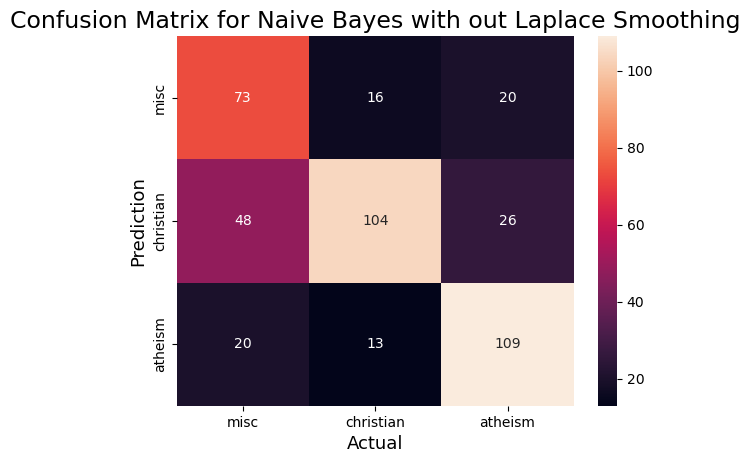


Report for Naive Bayes with Laplace Smoothing

              precision    recall  f1-score   support

           0       0.77      0.30      0.43       109
           1       0.62      0.90      0.74       178
           2       0.76      0.69      0.72       142

    accuracy                           0.68       429
   macro avg       0.72      0.63      0.63       429
weighted avg       0.70      0.68      0.65       429




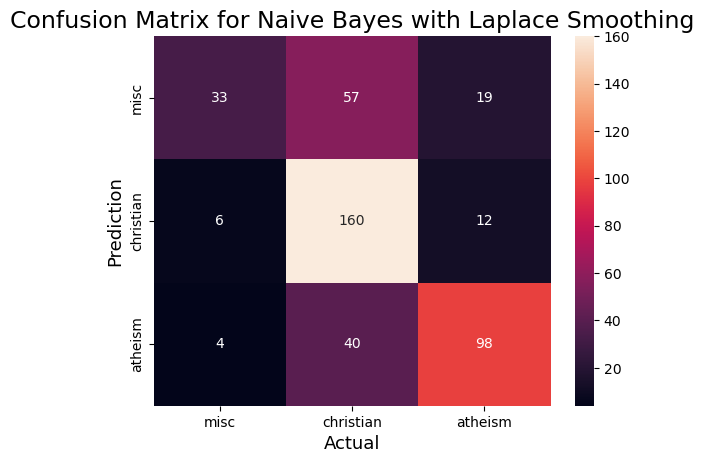

In [4]:
newsgroup.run()

## Running Review DataSet

Preprocessing Train Data


Calculating Probabilities of word given class: 100%|█████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


Preprocessing Test Data


Predicting class labels for Test Dataset: 100%|█████████████████████████████████████| 300/300 [00:02<00:00, 120.63it/s]


Report for Naive Bayes with out Laplace Smoothing

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       150
           1       0.84      0.81      0.82       150

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300




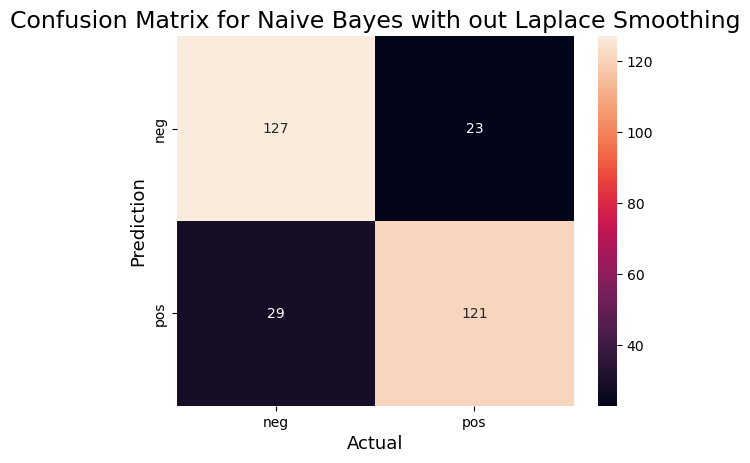


Report for Naive Bayes with Laplace Smoothing

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       150
           1       0.83      0.83      0.83       150

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300




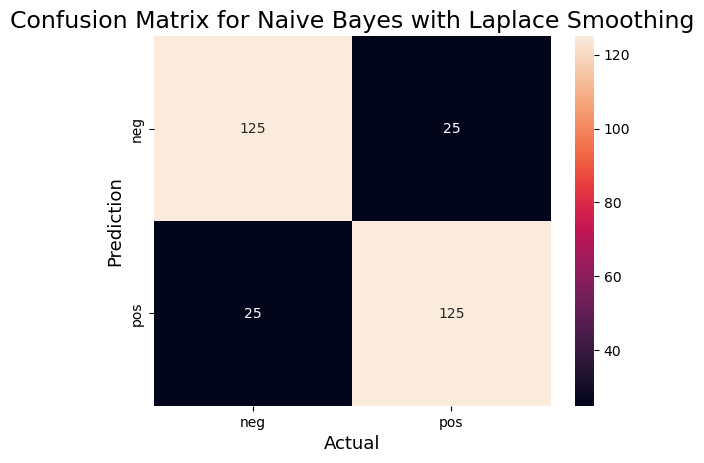

In [5]:
review.run()

## Plotting class distributions

Class Distributions for Movie Review dataset


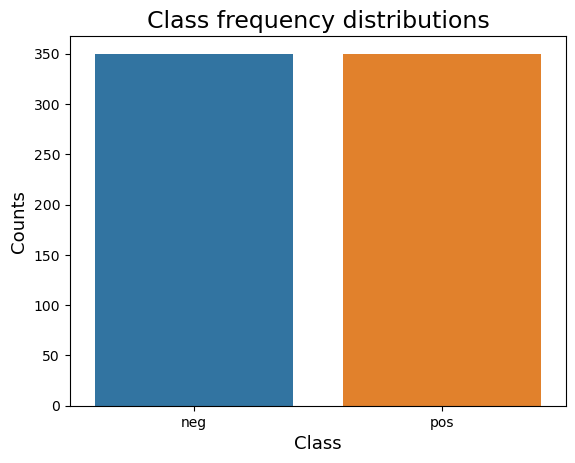


Class Distributions for Twenty Newsgroups dataset


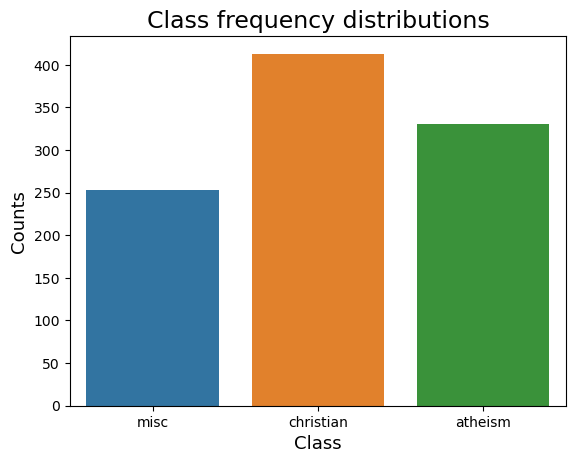

In [18]:
print("Class Distributions for Movie Review dataset")
values = list(review.class_counts['Text'])
keys = list(review.inv_map.keys())
sns.barplot(x=keys, y=values)
plt.ylabel('Counts',fontsize=13)
plt.xlabel('Class',fontsize=13)
plt.title('Class frequency distributions',fontsize=17)
plt.show()
print()
print("Class Distributions for Twenty Newsgroups dataset")
values = list(newsgroup.class_counts['Text'])
keys = list(newsgroup.inv_map.keys())
sns.barplot(x=keys, y=values)
plt.ylabel('Counts',fontsize=13)
plt.xlabel('Class',fontsize=13)
plt.title('Class frequency distributions',fontsize=17)
plt.show()

## Analyzing vocabulary of both datasets 

In [21]:
print(len(review.vocab))
print(review.vocab)

2153
{'0/10': 0, '1': 0, '10': 0, '1971': 0, '1986': 0, '1995': 0, '1998': 0, '2': 0, '20': 0, '3': 0, '30': 0, '4': 0, '5': 0, '5-year': 0, '7.50': 0, '70000': 0, '8.15pm': 0, '80': 0, '8pm': 0, '90': 0, 'absolutely': 0, 'abstruse': 0, 'abysmal': 0, 'accent': 0, 'accolade': 0, 'accuse': 0, 'achievement': 0, 'act': 0, 'action': 0, 'actor': 0, 'actress': 0, 'actually': 0, 'admiration': 0, 'admit': 0, 'adrift': 0, 'affleck': 0, 'afternoon': 0, 'age': 0, 'agree': 0, 'aimless': 0, 'air': 0, 'akin': 0, 'allison': 0, 'allow': 0, 'almost': 0, 'also': 0, 'always': 0, 'amateurish': 0, 'american': 0, 'amount': 0, 'angela': 0, 'angeles': 0, 'angle': 0, 'angry': 0, 'animal': 0, 'annoy': 0, 'annoying': 0, 'another': 0, 'anyone': 0, 'anything': 0, 'appal': 0, 'armageddon': 0, 'around': 0, 'art': 0, 'artiness': 0, 'artistic': 0, 'artless': 0, 'aside': 0, 'asleep': 0, 'aspect': 0, 'assault': 0, 'assistant': 0, 'astonishingly': 0, 'attempt': 0, 'attention': 0, 'audience': 0, 'audio': 0, 'austen': 0, 'a

In [22]:
print(len(newsgroup.vocab))
print(newsgroup.vocab)

25011
{'0': 0, '0050': 0, '023211': 0, '0mph': 0, '1': 0, '10': 0, '100': 0, '1000': 0, '1014': 0, '1015': 0, '1015matt': 0, '102': 0, '10acre': 0, '11': 0, '112': 0, '11213rara': 0, '1126': 0, '113': 0, '115': 0, '116': 0, '117': 0, '117rara': 0, '118': 0, '119': 0, '120': 0, '1200': 0, '122332': 0, '122426': 0, '122529': 0, '125': 0, '126': 0, '13': 0, '1310': 0, '1315': 0, '1329': 0, '1338': 0, '1338kingdom': 0, '14': 0, '14000': 0, '1417': 0, '142': 0, '142i': 0, '145': 0, '1459': 0, '15': 0, '150000': 0, '151825': 0, '15however': 0, '16': 0, '1666': 0, '167': 0, '17': 0, '1710': 0, '1723': 0, '173': 0, '17thcentury': 0, '18': 0, '18501905': 0, '1855': 0, '1876': 0, '188': 0, '1883': 0, '1895': 0, '19': 0, '1902in': 0, '1909but': 0, '1912': 0, '1915': 0, '1919': 0, '1921': 0, '1922': 0, '1925': 0, '1938': 0, '1963': 0, '1964': 0, '1966': 0, '1967': 0, '1968': 0, '1969the': 0, '1976': 0, '1978': 0, '1979': 0, '1981': 0, '1982': 0, '1982on': 0, '1984': 0, '1985': 0, '1988anyway': 0, 